# Proyecto pruebas A/B

## 1. Descripción de los objetivos del estudio

En este proyecto, debemos evaluar si introducir o no un sistema de recomendaciones que mejore el comportamiento de los usuarios frente al embudo de conversión, con respecto al grupo de control.

En ese orden de ideas, debemos plantear una prueba de hipótesis, donde su hipótesis nula sea: 'No hay diferencias en las tasas de conversión entre los grupos A y B'.

Identificamos 3 etapas del embudo: product_page → product_cart → purchase. Y se espera al menos un 10% de aumento en cada una.

La única condición de esta evaluación es que la conversión por etapa esté dentro de los 14 días posteriores al registro.

## 2. Exploración de datos

In [1]:
# Primero importamos las librerías correspondientes
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Cargamos los datasets
marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

In [3]:
# Revisamos qué contienen cada uno de nuestros datasets
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [5]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [6]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [7]:
# Convertimos los datos a los tipos que los necesitamos
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])

new_users['first_date'] = pd.to_datetime(new_users['first_date'])

events['event_dt'] = pd.to_datetime(events['event_dt'])

In [8]:
# Como ya sabemos (por info()) que tenemos datos ausentes, queremos saber si hay valores duplicados
print(marketing.duplicated().sum())
print(new_users.duplicated().sum())
print(events.duplicated().sum())
print(participants.duplicated().sum())

0
0
0
0


En nuestro dataset 'events' tenemos valores nulos en la columna 'detail'. Pero, como nos interesa conocer la conversión en cada parte del embudo y no los ingresos generados (de acuerdo con lo descrito, pertenecen a eventos purchase), nuestro análisis no depende de esta métrica y, por consiguiente, no produce sesgo. Por lo tanto, dejamos los valores nulos tal y como están.

## 3. Análisis exploratorio de datos

### Aplicamos los filtros a los datos brutos previo a nuestro análisis A/B

In [9]:
# Queremos saber cómo se distribuyen los participantes en cada prueba
participants['ab_test'].value_counts()

interface_eu_test          10850
recommender_system_test     3675
Name: ab_test, dtype: int64

In [10]:
# Filtramos los participantes por la prueba recommender_system_test
participants = participants[participants['ab_test'] == 'recommender_system_test']

In [38]:
# Filtramos por región en EU
new_users = new_users[new_users['region'] == 'EU']

In [43]:
# Filtramos por fechas de registro entre el 7 y el 21 de diciembre de 2020
new_users = new_users[(new_users['first_date'] >= '2020-12-07') & (new_users['first_date'] <= '2020-12-21')]

In [44]:
# Unimos las tablas new_users y participants
ab_users = new_users.merge(participants[['user_id', 'group']], on='user_id', how='inner')

In [45]:
# Verificamos si hay usuarios en ambos grupos
ab_users.groupby('user_id')['group'].nunique().value_counts()

1    3481
Name: group, dtype: int64

Podemos constatar que los participantes de la prueba pertenecen a un solo grupo (A o B).

In [46]:
# Unimos laas tablas events y ab_users
ab_events = events.merge(ab_users[['user_id', 'group']], on='user_id', how='inner')
ab_events['user_id'].nunique()

3481

In [47]:
# Filtramos los eventos dentro de 14 días del registro para verificar que sean los mismos usuarios
ab_events_filtered = ab_events.merge(ab_users[['user_id', 'first_date']], on='user_id')
ab_events_filtered = ab_events_filtered[ab_events_filtered['event_dt'] <= ab_events_filtered['first_date'] + pd.Timedelta(days=14)]
ab_events_filtered['user_id'].nunique()

3481

### Eventos por usuario

In [48]:

events_per_user = (ab_events.groupby(['user_id', 'group']).size().reset_index(name='events_count'))
events_per_user.groupby('group')['events_count'].describe()


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,2604.0,6.785714,3.733456,1.0,4.0,6.0,9.0,24.0
B,877.0,5.705815,3.455540,1.0,3.0,5.0,8.0,28.0


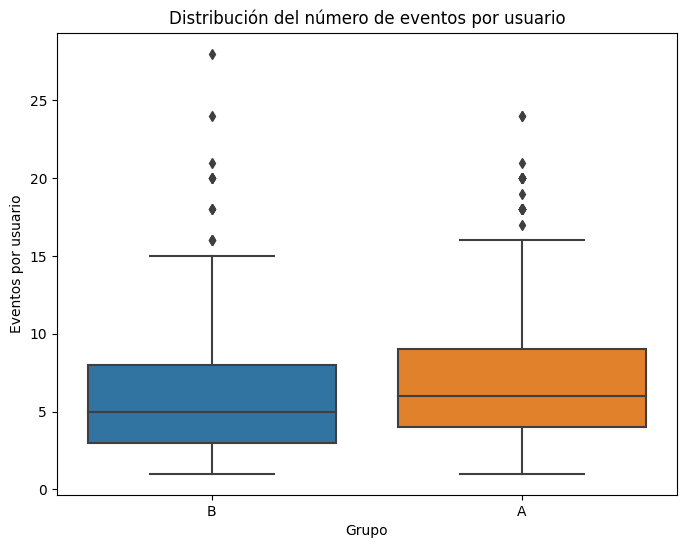

In [49]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=events_per_user, x='group', y='events_count')  # ✅ Con 's'
plt.title('Distribución del número de eventos por usuario')
plt.xlabel('Grupo')
plt.ylabel('Eventos por usuario')
plt.show()

Al verificar el número total de usuarios por grupo, podemos observar un desbalance significativamente grande entre los grupos A y B. Esto indica que se puede deber a que solo una fracción de los usuarios fue expuesta a los cambios del sistema para la prueba. Por lo tanto, debemos tener en cuenta que al tener un menor tamaño en el grupo B podemos tener diferencias estadísticas significativas con respecto al grupo A.

Adicionalmente, podemos darnos cuenta que, a pesar de que el número previsto de participantes es 6000 para esta prueba, en realidad hay 3481.

### Distribución de eventos por día

In [50]:
# Transformamos a formato date
ab_events['event_date'] = ab_events['event_dt'].dt.date

In [51]:
# Agrupamos los eventos por día
daily_events = (ab_events.groupby(['event_date', 'group']).size().reset_index(name='events'))
daily_events.head()

,event_date,group,events
0,2020-12-07,A,318
1,2020-12-07,B,356
2,2020-12-08,A,313
3,2020-12-08,B,238
4,2020-12-09,A,371


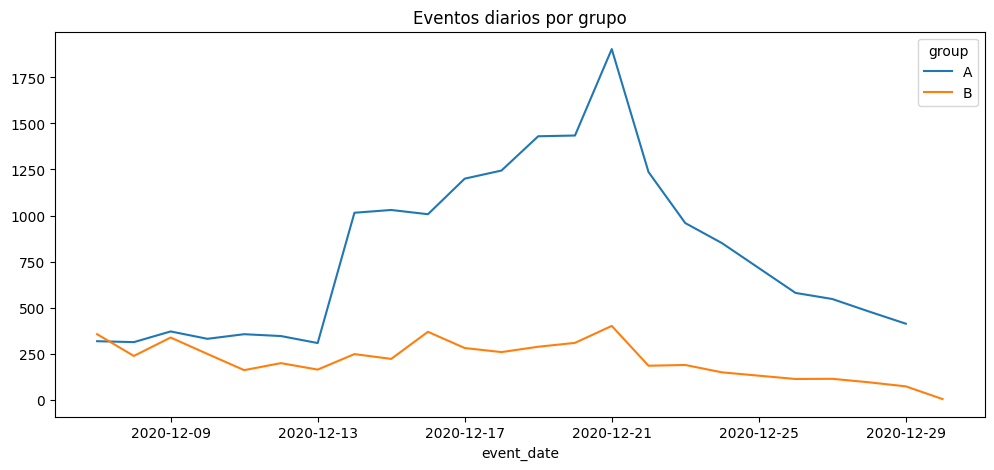

In [52]:
# Graficamos
daily_events.pivot(index='event_date', columns='group', values='events').plot(figsize=(12,5))

plt.title('Eventos diarios por grupo')
plt.show()

En nuestro gráfico vemos que, dadas las diferencias en el volumen de datos, los usuarios del grupo A tienen más actividad que los del grupo B, con picos más elevados (más de 1000 y 2000 eventos diarios).

El grupo A tiene picos muy marcados los días 15, 19 y 21 de diciembre, mientras que el grupo B tiene una curva más aplanada con picos menores los días 9, 16 y 21. Esto nos indica que el grupo A tiene una actividad más irregular y volátil, mientras que el grupo B es más estable pero consistentemente menor.

Esto puede deberse a que el grupo A tiene casi tres veces más usuarios que B, ya que hay un desbalance significativo que puede afectar la confiabilidad de las conclusiones.

### Embudo de conversión

In [53]:
# Definimos los eventos del embudo
funnel_events = ['product_page', 'product_cart', 'purchase']

In [54]:
# Buscamos los usuarios únicos por etapa y grupo
funnel = (ab_events[ab_events['event_name'].isin(funnel_events)].groupby(['group', 'event_name'])['user_id'].nunique().reset_index())

In [55]:
# Hacemos nuestra tabla de embudo por grupo
funnel_pivot = funnel.pivot(index='group', columns='event_name', values='user_id')
funnel_pivot

event_name,product_cart,product_page,purchase
group,,,
A,782,1685,833
B,244,493,249


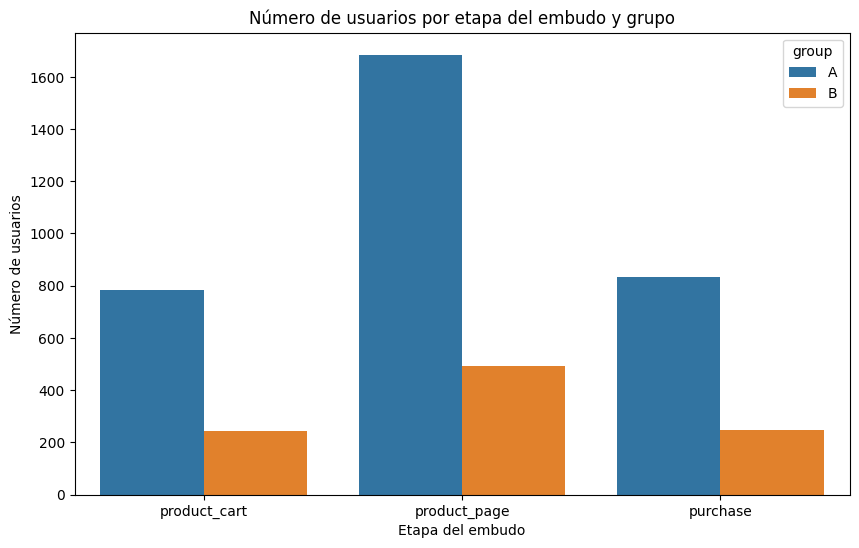

In [56]:
# Graficamos para visualizar mejor la conversión por etapa y grupo
plt.figure(figsize=(10, 6))

sns.barplot(data=funnel, x='event_name', y='user_id', hue='group')

plt.title('Número de usuarios por etapa del embudo y grupo')
plt.xlabel('Etapa del embudo')
plt.ylabel('Número de usuarios')
plt.show()

In [57]:
# Sacamos las conversiones en cada etapa
funnel_pivot['page_to_cart'] = (funnel_pivot['product_cart'] / funnel_pivot['product_page'])
funnel_pivot['cart_to_purchase'] = (funnel_pivot['purchase'] / funnel_pivot['product_cart'])
funnel_pivot['page_to_purchase'] = (funnel_pivot['purchase'] / funnel_pivot['product_page'])
funnel_pivot

event_name,product_cart,product_page,purchase,page_to_cart,cart_to_purchase,page_to_purchase
group,,,,,,
A,782,1685,833,0.464095,1.065217,0.494362
B,244,493,249,0.494929,1.020492,0.505071


Con esto, nos damos cuenta de que, para hacer una compra, el usuario no pasa necesariamente por el carrito de compras. Podemos entrar a evaluar si se debe a que hayan implementado un botón de compra directo desde la página del producto. Esto altera nuestra tasa de conversión de los usuarios que pasan por el carrito de compras a la etapa de compra (cart_to_purchase).

Sin embargo, podemos notar que las tasas de conversión entre A y B son muy similares en cada etapa, incluso es menor en la etapa de copra del grupo B. Por ahora, no podemos concluir nada al respecto, ya que como vimos no siempre se pasa por cada etapa del embudo para hacer una compra y estos reultados pueden estar afectando nuestro análisis.

Ahora, debemos buscar los usuarios que pasan por todo el embudo de conversión para finalizar nuestro análisis.

In [58]:
# Queremos los usuarios que pasaron por product_page → product_cart → purchase
def get_complete_funnel_users(events_df):
    # Usuarios por cada etapa
    page_users = set(events_df[events_df['event_name'] == 'product_page']['user_id'])
    cart_users = set(events_df[events_df['event_name'] == 'product_cart']['user_id'])
    purchase_users = set(events_df[events_df['event_name'] == 'purchase']['user_id'])
    # Agregamos los usuarios que pasaron por todas las etapas del embudo
    complete_funnel_users = page_users & cart_users & purchase_users
    return complete_funnel_users

# Aplicamos la función
complete_users = get_complete_funnel_users(ab_events)
print(f"Usuarios que siguieron el flujo completo: {len(complete_users)}")

Usuarios que siguieron el flujo completo: 216


In [59]:
# Filtramos solo eventos de usuarios que siguieron el flujo completo
ab_events_complete = ab_events[ab_events['user_id'].isin(complete_users)]

# Verificamos cuántos usuarios tenemos por grupo
users_by_group = ab_events_complete.groupby('group')['user_id'].nunique()
print(users_by_group)

group
A    170
B     46
Name: user_id, dtype: int64


Con esto nos damos cuenta que las personas que pasaron por el embudo de conversión es apenas el 10% de los participantes en el grupo A y 9% en el grupo B (que es incluso menor).

### Peculiaridades en los datos que hay que tener en cuenta antes de iniciar la prueba A/B

Analizando nuestros datos, debemos tener en cuenta las siguientes paticularidades hayadas en los datos, antes de realizar nuestras pruebas A/B:

1. Existe una gran diferencia entre el tamaño de las muestras del grupo A y el grupo B, siendo A mayor que B (2604 vs. 877).
2. La actividad diaria no es uniforme, con un aumento progresivo y picos el 15, 19 y 21 de diciembre, para el grupo A, lo que puede generar sesgo temporal. Mientras que en el grupo B, vemos una curva más aplanada con picos leves los días 9, 16 y 21, sin embargo, son mucho más bajos a los registrados en la actividad diaria del grupo A.
3. Algunos eventos de compra ocurren sin pasar por "agregar al carrito", lo que aumenta considerablemente la tasa de conversión del product_cart al purchase y, al identificar concretamente cuáles son esos usuarios que pasan por todos los eventos hasta la compra final, nos damos cuenta que es apenas un 10% y 9% respectivamente para cada grupo.

## 4. Evaluación de la prueba A/B

Teniendo en cuenta las particularidades a las que llegamos en nuestro punto anterior, queremos analizar ambas métricas para hacer un análisis completo. Es decir, queremos ver cómo se comporta: 
- La conversión directa: product_page → purchase (independiente del carrito)
- La conversión por etapas: product_page → product_cart → purchase

Planteamos nuestra hipótesis nula y alterna con un nivel de significancia de 0,05:

H0: No hay diferencia en las tasas de conversión entre el grupo A y el B.

Ha: Hay diferencia en las tasas de conversión entre el grupo A y el B.

Ahora, para comprobar si esta diferencia tan pequeña entre los dos grupos es significativa estadisticamente, realizamos la prueba Z.

In [61]:
# Realizamos la prueba z para product_page → purchase
purchases = [833, 249] 
ppage = [1685, 493]

z_stat, p_value = proportions_ztest(purchases, ppage)

print(f"Prueba z: {z_stat}")
print(f"P-value: {p_value}")

Prueba z: -0.41829376607931584
P-value: 0.6757323469354454


In [62]:
# Realizamos la prueba z para product_page → product_cart → purchases
ppurchases = [170, 46]
page = [1685, 493]

z_stat_page_cart, p_value_page_cart = proportions_ztest(ppurchases, page)

print(f"Prueba z: {z_stat_page_cart:.4f}")
print(f"P-value: {p_value_page_cart:.4f}")

Prueba z: 0.4955
P-value: 0.6202


Una vez realizada nuestra prueba Z para probar si implementar el sistema de recomendaciones aumentaría en por lo menos un 10% el embudo de conversión de clientes, podemos decir que no fue efectivo.
A nivel estadístico, nuestra prueba z nos indica que las proporciones entre grupos son prácticamente idénticas -0,418 para product_page → purchase y 0,4955 para el embudo completo. Y, con un P-value tan alto en ambas pruebas, nos dice que hay diferencia estadísticamente significativa entre grupos A y B, ya que son mucho mayores a nuestro nivel de significancia de 0,05 (0,676 y 0,6202) respectivamente), por lo que no podemos rechazar nuestra hipótesis nula.

## 5. Conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B

Problemas en la estructura de datos:
* Existe un desbalance significativo entre grupos (A: 2604 vs B: 877 usuarios).
* Tenemos un menor tamaño de muestra del esperado (3481 vs 6000 participantes previstos).

Patrones de comportamiento identificados:

* Solo 9-10% de usuarios completan el embudo tradicional (product_page → product_cart → purchase).
* Mayoría de compras son directas desde la página del producto, saltándose el carrito-
* Actividad diaria irregular con picos específicos que pueden introducir sesgo temporal.

Conclusiones de la Prueba A/B:

* Los p-values obtenidos (0,676 y 0,6202) sobre la efectividad del sistema de recomendaciones nos indica que no hay diferencia significativa entre implementarlo o no.
* Considerando el desbalance de muestras, creemos que esto afecta la confiabilidad de tus resultados. Probablemente, si ambos grupos tuvieran un mismo tamaño en sus muestras, pordrían ser comparables, ya que todas las condiciones serían equiparables para ambos grupos.


Recomendaciones específicas:

1. Se recomienda no implementar el sistema de recomendaciones, por lo menos, mientras se repite la prueba con un tamaño de muestras similar que nos de luz de si implementarla o no incrementaría los niveles de compra de los usuarios.
2. En caso de continuar con la implementación, se sugiere realizar monitoreo constante a las interacciones de los usuarios en cada etapa del embudo para ir haciendo ajustes.